In [1]:
cd ..

/Users/czyjtu/dev/deep-double-descent


# Get subset of the data

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch as th 
from pathlib import Path 
from datamodules.cifar10 import Cifar10DataModule
import wandb
from pathlib import Path


def download_weights_for_model(artifact_url, versions):
    paths = []
    run = wandb.init()
    for version in versions:
        artifact = run.use_artifact(f'{artifact_url}:v{version}', type='model')
        artifact_dir = artifact.download()
        paths.append(Path(artifact_dir).resolve())
    return paths

def get_stratified_subset(dataloader, frac: float):
    X, y = [], []
    for X_batch, y_batch in dataloader:
        X.append(X_batch)
        y.append(y_batch)
    X = np.concatenate(X)
    y = np.concatenate(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=frac, stratify=y, random_state=1)
    return DataLoader(TensorDataset(th.from_numpy(X_test), th.from_numpy(y_test)), batch_size=32, shuffle=False)


datamodule = Cifar10DataModule()
datamodule.setup("test")
test_loader = datamodule.test_dataloader()

subsset_loader = get_stratified_subset(test_loader, 0.2)
y_true = []
for X_batch, y_batch in subsset_loader:
    y_true.append(y_batch)
y_true = np.concatenate(y_true)
y_true = np.eye(y_true.max() + 1)[y_true] # convert to one-hot

Files already downloaded and verified


# Load models from checkpoints

In [3]:
from tasks.cifar import LitCNN
import torch as th 

def load_models_from_artifacts(artifact_url, versions) -> list[LitCNN]:
    paths = download_weights_for_model(artifact_url, versions)
    models = [LitCNN.load_from_checkpoint(path / "model.ckpt", map_location=th.device('cpu')) for path in paths]
    return models 


models = {
    "before": load_models_from_artifacts("czyjtu/deep-double-descent/model-2r9z9yog", range(1, 17)),
    "peak": load_models_from_artifacts("czyjtu/deep-double-descent/model-qcr3on2v", range(1, 17)),
    "after": load_models_from_artifacts("czyjtu/deep-double-descent/model-rpyh9mg4", range(1, 17))
}

Global seed set to 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: czyjtu (automobile-racing-toolbox). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


# Extract activations 

In [4]:
from tqdm import tqdm 

def get_last_layer_activations(model: LitCNN, dataloader):
    global view_output
    def hook_fn(module, input, output):
        global view_output
        view_output = output
    hook = model.model[-2].register_forward_hook(hook_fn)

    views = []
    predictions = []
    for X, y in dataloader:
        y_hat = model(X)
        predictions.append(y_hat.argmax(dim=1).detach().numpy())
        views.append(view_output.detach().numpy())
    hook.remove()
    return np.concatenate(views), np.concatenate(predictions)

activations_per_model = {}
for key, epochs in models.items():
    activations_per_epoch, labels_per_model = zip(*[get_last_layer_activations(model, subsset_loader) for model in tqdm(epochs)])
    activations_per_model[key] = activations_per_epoch

100%|██████████| 16/16 [00:35<00:00,  2.20s/it]


In [5]:
import pickle 
pickle.dump(activations_per_model, open("activations_per_model.pkl", "wb"))

In [6]:
assert np.all(activations_per_model["before"][0] != activations_per_model["after"][0])

/var/folders/j2/83k2pfk133n_vkpjy9xj72c00000gn/T/ipykernel_6325/2939344567.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assert np.all(activations_per_model["before"][0] != activations_per_model["after"][0])


# inter-epoch evolution

before


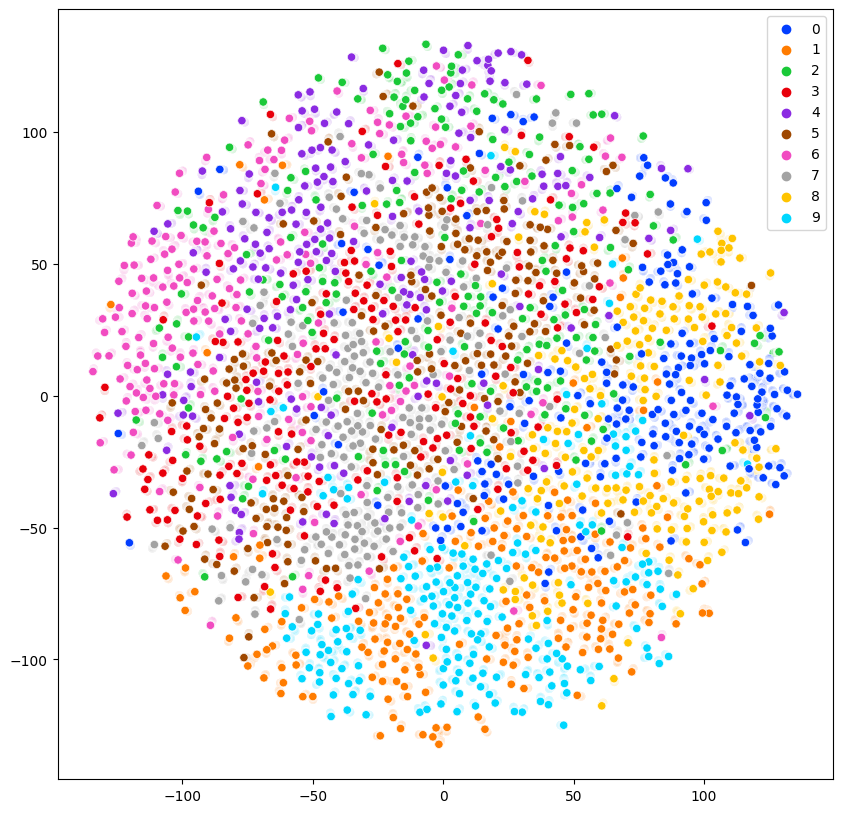

peak


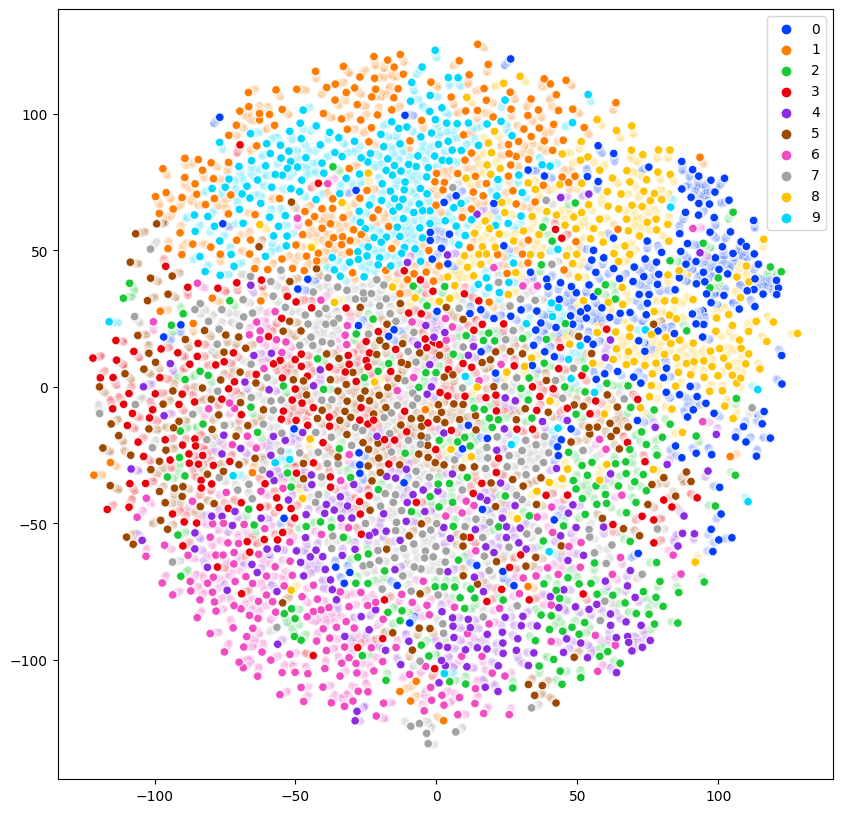

after


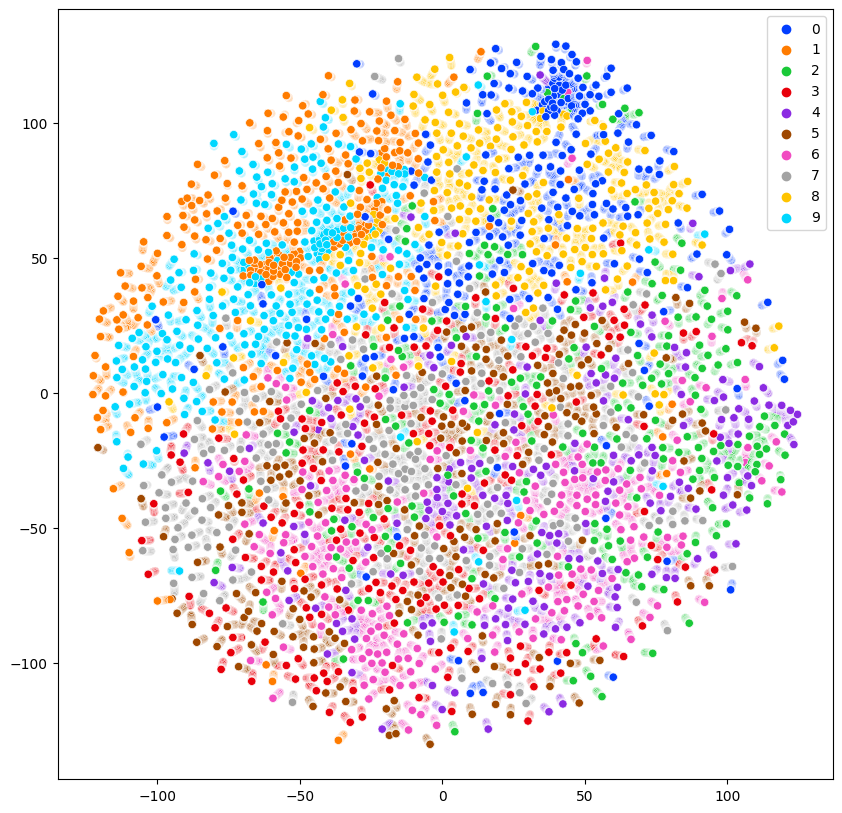

In [7]:
from utils import *

points_list_per_model = {}
for key, activations in activations_per_model.items():
    print(key)
    points_list, targets = process_activations(activations, y_true, 2000)
    points_list_per_model[key] = points_list

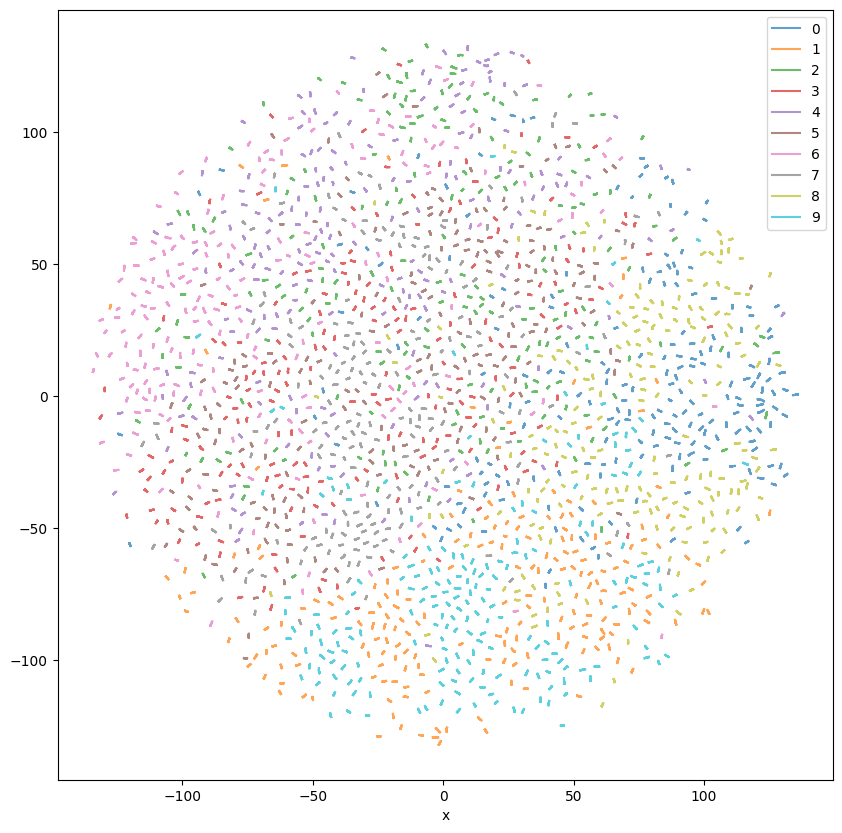

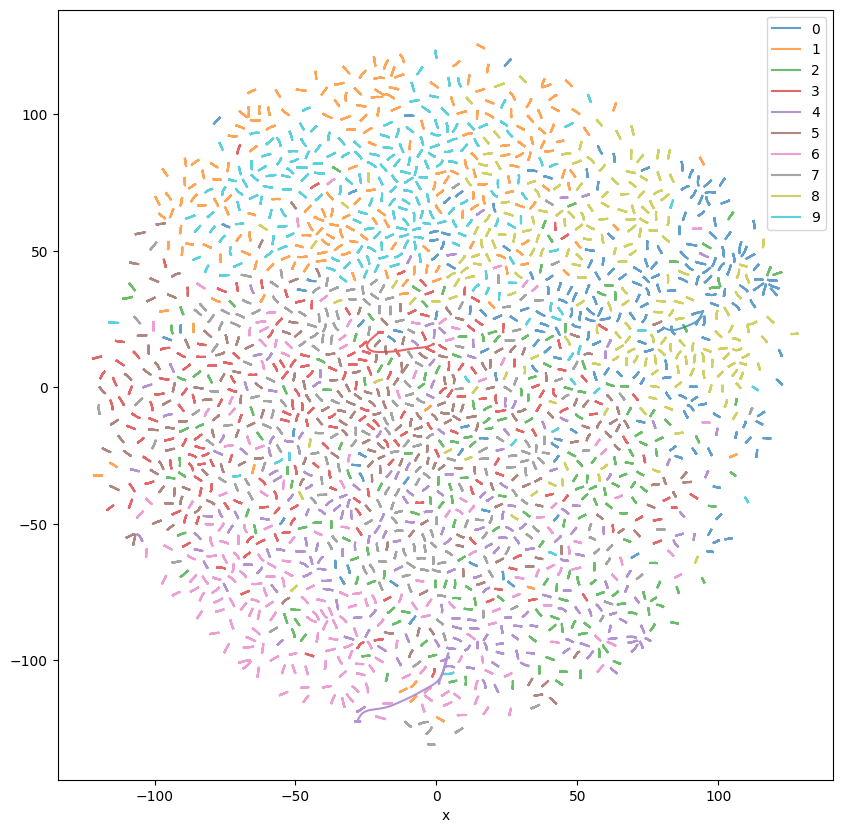

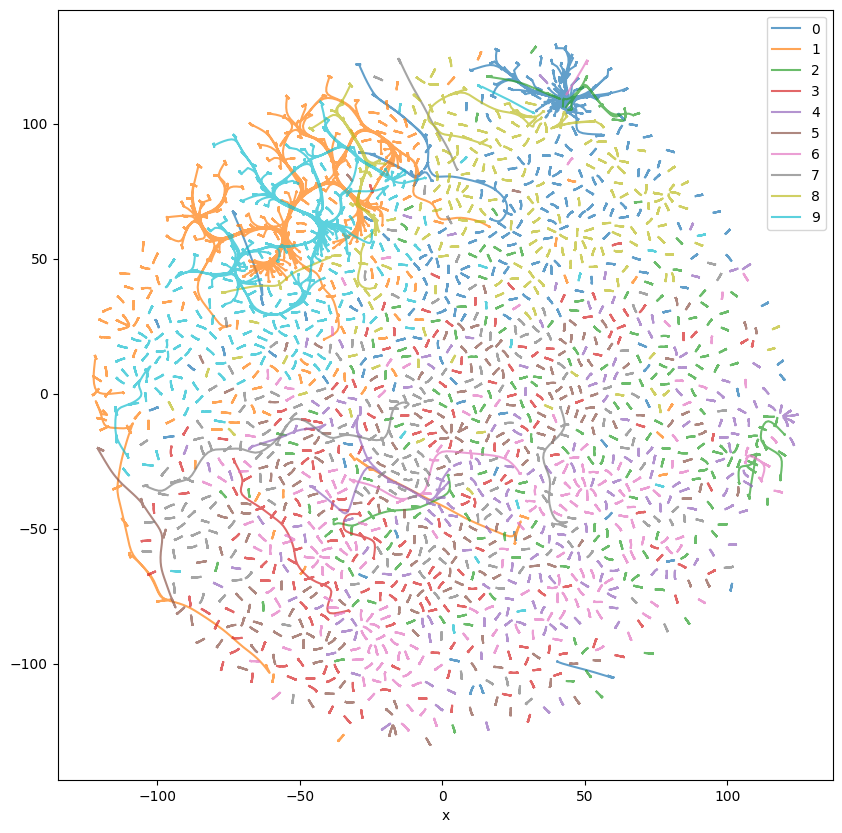

In [8]:
for key, points_list in points_list_per_model.items():
    inter_epoch_evolution(points_list, np.argmax(y_true, axis=1))

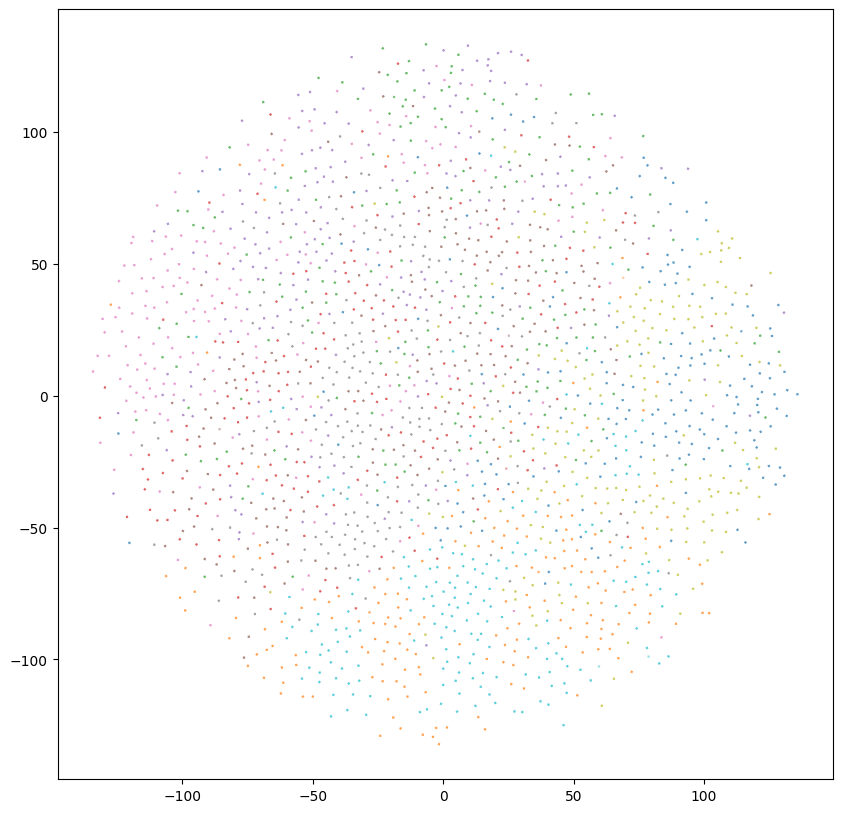

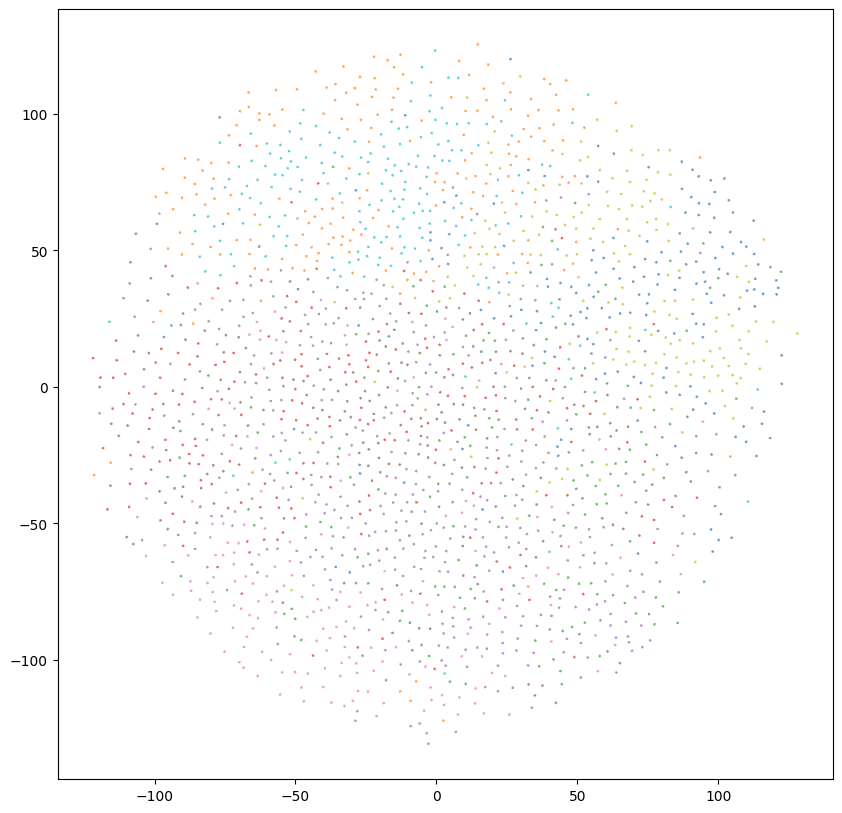

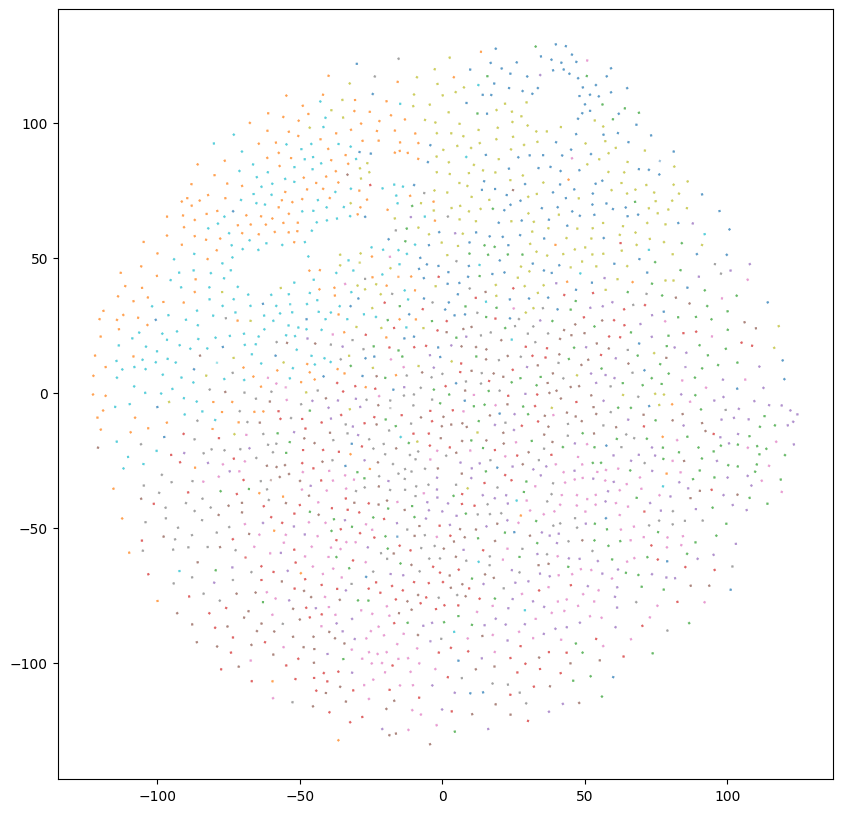

In [9]:
def show_trace(points, targets):
    cmap = plt.get_cmap("tab10")

    fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(points[0])):
        for p in range(len(points) - 1):
            color = cmap(targets[i])
            alpha = 2 ** (1 + p - len(points))
            color = (*color[:3], alpha)
            xs = [points[p][i][0], points[p + 1][i][0]]
            ys = [points[p][i][1], points[p + 1][i][1]]
            ax.plot(xs, ys, c=color)

    plt.show()

for key, points_list in points_list_per_model.items():
    show_trace(points_list, np.argmax(y_true, axis=1))